# Tree segmentation with Sentinel 1/2 imagery - UNET Baseline

## John Brandt
## April 20, 2020

## Overview

This notebook contains the TensorFlow model training and prediction used to segment trees for [Restoration Mapper](https://restorationmapper.org). The notebook uses tensorflow 1.13.1 and additionally relies on Keras and tflearn. 

## Table of Contents

- Package loading
- Utility scripts
- Hyperparameter definitions
- Custom tensorflow layer functions
- Tensorflow graph creation
- Data loading
- Data preprocessing
- Equibatch creation
- Loss definition
- Tensorflow graph initialization
- Training
- Model validation
- Sanity Checks

## Package Loading

In [1]:
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.python.keras.activations import selu
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


## Utility scripts

In [2]:
%run ../../src/layers/zoneout.py
%run ../../src/layers/convgru.py
%run ../../src/layers/adabound.py
%run ../../src/layers/dropblock.py
%run ../../src/layers/extra_layers.py
%run ../../src/preprocessing/indices.py
%run ../../src/preprocessing/slope.py
%run ../../src/utils/metrics.py

# Hyperparameter definitions

In [3]:
ZONE_OUT_PROB = 0.20
N_FILTERS = 32
AVERAGE_GRU_FILTERS = True
ACTIVATION_FUNCTION = 'relu'

INITIAL_LR = 1e-4
FINAL_LR = 2e-2
DROPBLOCK_MAXSIZE = 5
DECONV = 'nearest'
N_CONV_BLOCKS = 1
FINAL_ALPHA = 0.7
LABEL_SMOOTHING = 0.075
BATCH_RENORM = 'norm'

L2_REG = 0.0
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
MAX_DROPBLOCK = 0.85

gru_flt = 32
fpa_flt = 28
out_conv_flt = 32

IMAGE_SIZE = 16
LABEL_SIZE = 14

# Hyperparameter grid search definitions

In [4]:
# There are 3.8 million combinations of hyperparameters
params = {
    'out_conv_filter': range(16, 64, 16), # 5
    'activation_function': ['relu', 'selu', 'elu'], # 3
    'final_lr': [5e-3, 1e-2, 2e-2, 5e-2], # 4
    'dropblock_maxsize': [7, 6, 5, 4, 3], # 5
    'label_smoothing': [0., 0.025, 0.05, 0.075, 0.10, 0.125],
    'batch_renorm': ['renorm', 'norm']
}

# Custom layer definitions

### Utility blocks (Batch norm, cSSE, etc.)

In [5]:
def Batch_Normalization(x, training, scope, clipping_params):
    '''Batch renormalization layer from tensorflow.layers

         Parameters:
          x (tf.Variable): input layer
          training (tf.Variable): flag to differentiate between train/test ops
          scope (str): tensorflow scope
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          x (tf.Variable): output of batch renormalization
          
         References:
          https://github.com/tensorflow/docs/blob/r1.13/site/en/
          api_docs/python/tf/layers/batch_normalization.md
    '''
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               renorm_clipping = clipping_params,
                               name = scope)


def calc_renorm_params(epoch, n_samples, batch_size, k = 0):
    '''Calculates the clipping parameters for renormalization
       based on the learning schedule outlined in the original paper
       where rmax is initialized to 1, dmax to 0, rmin to 0,
       (effectively batch normalization), and then rmax and dmax
       are gradually reaxed to 3 and 5 over 40k and 25k steps,
       respectively. In this case, 40k has been reduced to 30k, and 25k
       has been reduced to 20k.

         Parameters:
          epoch (int): number of current training epoch
                       if testing, epoch number of model used
          n_samples (int): total number of training samples
          batch_size (int): training batch size 

         Returns:
          rmax (float)
          dmax (float)
          rmin (float)
    '''
    step = epoch * (n_samples // batch_size)
    step += k
    if step < 2500:
        rmax = 1.
        dmax = 0.
        rmin = 0.
    if step >= 2500:
        rmax = np.min([1 + 2*((step-2500)/25000), 3])
        dmax = np.min([1 + 5*((step-2500)/15000), 5])
        rmin = 0.
    return rmax, dmax, rmin

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

### Conv blocks

In [6]:
def conv_selu(inp, is_training, kernel_size, scope,
                filter_count = 16, pad = True, padding = 'valid', dilated = False,
                activation = True):
    '''Convolutional 2D layer with SELU activation and Lecun normal initialization
       with no batch norm. Only used if params['activation'] = 'selu'

         Parameters:
          inp (tf.Variable): (B, H, W, C) input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): kernel size of convolution
          scope (str): tensorflow variable scope
          filter_count (int): number of convolution filters
          pad (bool): whether or not to reflect pad input
          padding (str): one of ['valid', 'same']
          dilated (bool): whether to perform atruous convolution
          activation (bool): whether to activate output

         Returns:
          conv (tf.Variable): output of Conv2D -> SELU
          
         References:
          https://arxiv.org/abs/1706.02515
    '''
    if activation:
        act = selu
    else:
        act = None
    if not dilated:
        padded = ReflectionPadding2D((1, 1,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    if not dilated and not pad:
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(inp)
    if dilated:
        padded = ReflectionPadding2D((2, 2,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (3, 3), activation = act, dilation_rate = (2, 2),
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    return conv

def conv_bn_relu(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 clipping_params,
                 keep_rate,
                 activation = True,
                 use_bias = False,
                 batch_norm = True):
    
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization
          activation (bool): whether to apply RELU
          use_bias (str): whether to use bias. Should always be false

         Returns:
          bn (tf.Variable): output of Conv2D -> Batch Norm -> RELU
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size), 
                  activation = None, padding = 'valid', use_bias = use_bias,
                  kernel_initializer = tf.keras.initializers.he_normal())(inp)
    if batch_norm:
        conv = Batch_Normalization(conv, is_training, scope, clipping_params)
    if activation:
        conv = tf.nn.relu(conv)
    drop_block = DropBlock2D(keep_prob=keep_rate, block_size=3)
    conv = drop_block(conv, is_training)

    return conv

# Model definition

## Placeholders

In [7]:
n_bands = 16*12
reg = keras.regularizers.l2(L2_REG) # for GRU
inp = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, n_bands))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling

In [8]:
rmax = tf.placeholder(tf.float32, shape = ())
rmin = tf.placeholder(tf.float32, shape = ())
dmax = tf.placeholder(tf.float32, shape = ())

clipping_params = {
    'rmax': rmax,
    'rmin': rmin,
    'dmax': dmax
}

## Layers

In [9]:
# DOWN 1
print("Input: {}".format(inp.shape))
x1 = ReflectionPadding2D((1, 1,))(inp)
conv1 = conv_bn_relu(inp = x1, 
                 is_training = is_training, kernel_size = 3,
                 scope = "conv1", filters = N_FILTERS, 
                 clipping_params = clipping_params,
                 activation = True, keep_rate = keep_rate, 
                 use_bias = False, batch_norm = True)
print("Conv1: {}".format(conv1.shape))



x1 = ReflectionPadding2D((1, 1,))(conv1)
x = conv_bn_relu(inp = x1, 
                 is_training = is_training, kernel_size = 3,
                 scope = "conv2", filters = N_FILTERS, 
                 clipping_params = clipping_params,
                 activation = True, keep_rate = keep_rate, 
                 use_bias = False, batch_norm = True)
print("Conv2: {}".format(x.shape))


down16 = tf.concat([x, conv1], axis = -1)
print(down16.shape)

maxpool1 = MaxPool2D(pool_size=(2, 2), strides=None)(down16)
print("Maxpool: {}".format(maxpool1.shape))


# DOWN 2
x1 = ReflectionPadding2D((1, 1,))(maxpool1)
x1 = conv_bn_relu(inp = x1, 
                 is_training = is_training, kernel_size = 3,
                 scope = "conv9", filters = N_FILTERS*2, 
                 clipping_params = clipping_params,
                 activation = True, keep_rate = keep_rate, 
                 use_bias = False, batch_norm = True)

x1 = ReflectionPadding2D((1, 1,))(x1)
x = conv_bn_relu(inp = x1, 
                 is_training = is_training, kernel_size = 3,
                 scope = "conv10", filters = N_FILTERS*2, 
                 clipping_params = clipping_params,
                 activation = True, keep_rate = keep_rate, 
                 use_bias = False, batch_norm = True)

down8 = tf.concat([x, maxpool1], axis = -1)
maxpool2 = MaxPool2D(pool_size=(2, 2), strides=None)(down8)
print("Maxpool 2: {}".format(maxpool2.shape))

# 4x4 Block
x1 = ReflectionPadding2D((1, 1,))(maxpool2)
x1 = conv_bn_relu(inp = x1, 
                 is_training = is_training, kernel_size = 3,
                 scope = "conv13", filters = N_FILTERS*4, 
                 clipping_params = clipping_params,
                 activation = True, keep_rate = keep_rate, 
                 use_bias = False, batch_norm = True)
x1 = ReflectionPadding2D((1, 1,))(x1)
print("Down mid: {}".format(x1.shape))

x = conv_bn_relu(inp = x1, 
                 is_training = is_training, kernel_size = 3,
                 scope = "conv14", filters = N_FILTERS*4, 
                 clipping_params = clipping_params,
                 activation = True, keep_rate = keep_rate, 
                 use_bias = False, batch_norm = True)
print("Down out: {}".format(x.shape))

# UPSAMPLING 4 - 8
three_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(x)
three_up = tf.concat([three_up, down8], axis = -1)

three_up = ReflectionPadding2D((1, 1,))(three_up)
three_up = conv_bn_relu(inp = three_up, is_training = is_training, 
           kernel_size = 3, scope =  'upconv1',
           filters = N_FILTERS*2, clipping_params = clipping_params,
           keep_rate = keep_rate, activation = True,
           use_bias = False, batch_norm = True)
print(three_up.shape)

x1 = ReflectionPadding2D((1, 1,))(three_up)
x = conv_bn_relu(inp = x1, 
                 is_training = is_training, kernel_size = 3,
                 scope = "convup1", filters = N_FILTERS*2, 
                 clipping_params = clipping_params,
                 activation = True, keep_rate = keep_rate, 
                 use_bias = False, batch_norm = True)

# Upsampling 8 - 16
three_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(three_up)
three_up = tf.concat([three_up, down16], axis = -1)
three_up = ReflectionPadding2D((1, 1,))(three_up)
three_up = conv_bn_relu(inp = three_up, is_training = is_training, 
           kernel_size = 3, scope =  'upconv2',
           filters = N_FILTERS, clipping_params = clipping_params,
           keep_rate = keep_rate, activation = True,
           use_bias = False, batch_norm = True)
print(three_up.shape)

x1 = ReflectionPadding2D((1, 1,))(three_up)
x = conv_bn_relu(inp = x1, 
                 is_training = is_training, kernel_size = 3,
                 scope = "convup2", filters = N_FILTERS, 
                 clipping_params = clipping_params,
                 activation = True, keep_rate = keep_rate, 
                 use_bias = False, batch_norm = True)

# Out block
x = conv_bn_relu(inp = three_up, 
                 is_training = is_training, kernel_size = 3,
                 scope = "convout", filters = N_FILTERS, 
                 clipping_params = clipping_params,
                 activation = True, keep_rate = keep_rate, 
                 use_bias = False, batch_norm = True)
print(x.shape)

# 

print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(x) # For focal loss

Input: (?, 16, 16, 192)
Conv1: (?, 16, 16, 32)
Conv2: (?, 16, 16, 32)
(?, 16, 16, 64)
Maxpool: (?, 8, 8, 64)
Maxpool 2: (?, 4, 4, 128)
Down mid: (?, 6, 6, 128)
Down out: (?, 4, 4, 128)
(?, 8, 8, 64)
(?, 16, 16, 32)
(?, 14, 14, 32)
Initializing last sigmoid bias with -2.94 constant


In [10]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 674145 parameters


# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate NDVI, EVI, SAVI, BI, MSAVI2, and SI
*  Stack X, Y, length data
*  Apply median filter to DEM

In [11]:
train_x = np.load("../../tile_data/processed/data_x_l2a_processed.npy")
train_y = np.load("../../tile_data/processed/data_y_l2a_processed.npy")

train_x = np.delete(train_x, 14, -1) 

# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Identify and remove samples with null data, or samples with extreme band 0 data (which squash all the "clean" samples)
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

In [12]:
below_1 = [i for i, val in enumerate(train_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(train_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(train_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(train_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(train_x) if np.sum(np.isnan(val)) > 0]
oob_vals = [i for i, val in enumerate(train_x) if np.max(val[:, :, :, 0]) > 0.7]

outliers = below_1 + above_1 + nans + oob_vals
outliers = list(set(outliers))
print("Removing {} outlying training data points".format(len(outliers)))
print("\n")

train_x = train_x[[x for x in range(0, len(train_x)) if x not in outliers]]
train_y = train_y[[x for x in range(0, len(train_y)) if x not in outliers]]

Removing 42 outlying training data points




## Min, Max scaling

In [13]:
min_all = []
max_all = []

for band in range(0, train_x.shape[-1]):
    mins = np.percentile(train_x[:, :, :, :, band], 1)
    maxs = np.percentile(train_x[:, :, :, :, band], 99)

    train_x[:, :, :, :, band] = np.clip(train_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (train_x[:, :, :, :, band] - midrange) / (rng / 2)
    train_x[:, :, :, :, band] = standardized
    
    min_all.append(mins)
    max_all.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(train_x), np.max(train_x)))

The data has been scaled to [-1.0000001192092896, 1.000000238418579]


# Augment training data

Horizontal and vertical flips for 4x augmentation.

**To do**
*  Random guassian noise
*  Brightness, contrast
*  Region swaps (randomply position positive samples at different locations)

## Load and process test data

In [14]:
test_x = np.load("../../tile_data/processed/test_x_l2a_processed.npy")
test_y = np.load("../../tile_data/processed/test_y_l2a_processed.npy")

test_x = np.delete(test_x, 14, -1)

below_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.67]
above_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.67]
min_vals = [np.min(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))
print("There are {} outliers".format(len(outliers)))
print("\n")
print(min_vals, max_vals)
        
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)

There are 8 outliers


[-1.7179548, -1.5627671, -1.8532804, -1.7344598, -1.566039, -1.5506328, -1.5647379, -1.5482582, -1.5288317, -1.6640986, -1.5696894, -1.6236508, -1.6086293, -1.8026409, -1.6395152, -1.7323623, -1.8079871, -1.6267077] [1.6422757, 1.6066049, 1.7172077, 1.5512294, 1.5134994, 1.6136878, 1.644342, 1.5873938, 1.7966671, 1.7034032, 1.5901011, 1.7489257, 1.6376961, 1.6454076, 1.6791666, 1.7280316]



The data has been scaled to [-1.0000001192092896, 1.000000238418579]
(1103, 24, 16, 16, 16)


In [15]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in test_y])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in test_y])))
#print("Train number with zero trees {}".format(0.2*len([x for x in data_y[train_ids] if np.sum(x) == 0])))
#print("Test number with zero trees {}".format(0.8*len([x for x in data_y[test_ids] if np.sum(x) == 0])))
print("Train mean NDVI")
print("Test mean NDVI")
#print("There are {} train and {} test samples".format(len(train_ids), len(test_ids)))
#print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))

Train and test characteristics:
Train mean Y 71.71894832275612
Test STD Y 78.74022194028825
Train mean NDVI
Test mean NDVI


# Equibatch creation

The modelling approach uses equibatch sampling to ensure that there is a near constant standard deviation of the percent tree cover in the output labels for each batch. This helps ensure that the model performs equally well across gradients of tree cover, by mitigating the random possibility that many batches in a row near the end of sampling may be randomly biased towards a tree cover range.

In [16]:
sums = np.sum(train_y, axis = (1, 2))
percents = [np.percentile(sums, x) for x in range(3*10, 100, 10)]
print(percents)
print("There are {} zeros".format(len(np.argwhere(sums == 0))))

[6.0, 14.0, 23.0, 36.0, 61.0, 116.0, 183.30000000000018]
There are 807 zeros


In [17]:
train_ids = [x for x in range(0, len(train_y))]

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots
    
         Parameters:
          matrices (list of arrays):

         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])

def equibatch(train_ids, p = percents, lovasz = False):
    '''Docstring
    
         Parameters:
          train_ids (list):
          p (list):
          lovasz (bool):

         Returns:
          equibatches (list):
    '''
    percents = [7.0, 13.0, 21.0, 33.0, 50.0, 80.0, 130.0] # overall
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    ids0 = [x for x, z in zip(ix, percs) if z <= 2]
    ids30 = [x for x, z in zip(ix, percs) if 2 < z < percents[0]]
    ids40 = [x for x, z in zip(ix, percs) if percents[0] < z < percents[1]]
    ids50 = [x for x, z in zip(ix, percs) if percents[1] < z < percents[2]]
    ids60 = [x for x, z in zip(ix, percs) if percents[2] < z < percents[3]]
    ids70 = [x for x, z in zip(ix, percs) if percents[3] < z < percents[4]]
    ids80 = [x for x, z in zip(ix, percs) if percents[4] < z < percents[5]]
    ids90 = [x for x, z in zip(ix, percs) if percents[5] < z < percents[6]]
    ids100 = [x for x, z in zip(ix, percs) if percents[6] < z]
    

    new_batches = []
    maxes = [len(ids0), len(ids30), len(ids40), len(ids50), len(ids60), len(ids70),
             len(ids80), len(ids90), len(ids100)]
    print(maxes)
    cur_ids = [0] * len(maxes)
    iter_len = len(train_ids)//(len(maxes))
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [ids0[cur_ids[0]],
                    ids30[cur_ids[1]], ids40[cur_ids[2]],
                    ids50[cur_ids[3]],
                    ids60[cur_ids[4]], ids70[cur_ids[5]], ids80[cur_ids[6]],
                    ids90[cur_ids[7]], ids100[cur_ids[8]]]
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        
    new_batches = [item for sublist in new_batches for item in sublist]
    return new_batches

batch = equibatch(train_ids)

[986, 324, 302, 341, 384, 358, 342, 297, 791]


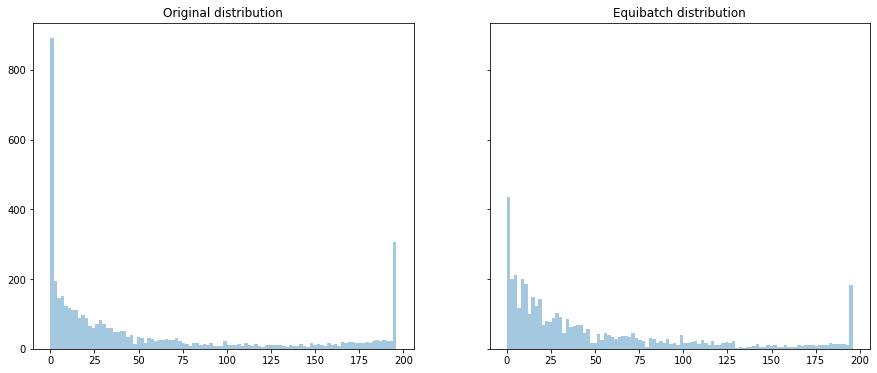

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(15, 6)
sns.distplot(np.sum(train_y, axis = (1, 2)), bins = 100, kde = False, ax = ax1)
ax1.set_title('Original distribution')
ax2.set_title('Equibatch distribution')
sns.distplot(np.sum(train_y[batch], axis = (1, 2)),
             bins = 100, kde = False, ax = ax2)

plt.show()

## Weight cross entropy by effective number of samples

In [19]:
sum_pos = np.sum(train_y[batch])
sum_neg = len(train_y[batch]) * 196 - sum_pos
beta = (sum_pos + sum_neg - 1) / (sum_pos + sum_neg)
print("Beta: {}".format(beta))
samples_per_cls = np.array([sum_neg, sum_pos])
effective_num = 1.0 - np.power(beta, samples_per_cls)
print(effective_num)
weights = (1.0 - beta) / np.array(effective_num)
weights = weights / np.sum(weights)
print("Neg and pos weights: {}".format(weights))
weight = weights[1] / weights[0]
print(weight)


Beta: 0.9999988263076107
[0.52668243 0.22276448]
Neg and pos weights: [0.2972385 0.7027615]
2.3643017091033465


In [20]:
print("Baseline: The positive is: {}".format(weights[0]))
print("Baseline: The negative is: {}".format(weights[1]))
print("\n")
print("Balanced: The positive is: {}".format(weight*weights[0]))
print("Balanced: The negative is: {}".format(weights[1]))

Baseline: The positive is: 0.29723850191382506
Baseline: The negative is: 0.7027614980861749


Balanced: The positive is: 0.7027614980861749
Balanced: The negative is: 0.7027614980861749



# Loss definition

The current best loss is a combination of weighted binary cross entropy and per-image Lovasz-Softmax, with a loss schedule with the latter becoming more important each epoch

In [21]:
import math

def weighted_bce_loss(y_true, y_pred, weight, mask = None, smooth = 0.025):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr):
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    return tf.reduce_mean(loss)

# Evaluation metrics

In [22]:
countries = {'africaeast-test': [0, 34],
 'africawest-test': [35, 96],
 'cameroon-test': [97, 135],
 'ethiopia-test': [136, 248],
 'ghana-test': [249, 282],
 'ghana-test-large': [283, 318],
 'global-test': [319, 460],
 'india-test': [461, 511],
 'kenya-test': [512, 600],
 'lac-north-test': [601, 641],
 'lac-south-test': [642, 683], 'all': [0, 683]}

def dice_loss(y_true, y_pred):
    '''Calculates the dice score of ground truth and prediction arrays
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          metric (arr):
    '''
    numerator = 2 * np.sum(y_true * y_pred, axis=-1)
    denominator = np.sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)

def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    fp = 0
    tp = 0
    fn = 0
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1                
                
    precision =  np.sum(tp) / (np.sum(tp) + np.sum(fp))
    recall = np.sum(tp) / (np.sum(tp) + np.sum(fn))
    f1 = 2 * ((precision * recall) / (precision + recall))
    return np.sum(tp), np.sum(fp), np.sum(fn)

def calculate_metrics(country, al = 0.4, canopy_thresh = 100):
    '''Calculates the following metrics for an input country, based on
       indexing of the country dictionary:
       
         - Loss
         - F1
         - Precision
         - Recall
         - Dice
         - Mean surface distance
         - Average error
    
         Parameters:
          country (str):
          al (float):
          
         Returns:
          val_loss (float):
          best_dice (float):
          error (float):
    '''
    print(canopy_thresh)
    start_idx = countries[country][0]
    stop_idx = countries[country][1]
    best_f1 = 0
    best_dice = 0
    best_thresh = 0
    p = 0
    r = 0
    error = 0
    d = 0
    ys = []
    vls = []
    t_alls = []
    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        if np.sum(test_y[test_sample]) < ((canopy_thresh/100) * 197) :
            y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[test_sample].reshape(1, 16, 16, n_bands),
                                              is_training: False,
                                              clipping_params['rmax']: rmax_epoch,
                                              clipping_params['rmin']: rmin_epoch,
                                              clipping_params['dmax']: dmax_epoch,
                                              labels: test_y[test_sample, :, :].reshape(1, 14, 14),
                                              })
            ys.append(y.reshape((14, 14)))
            vls.append(vl)
            t = test_y[test_sample].reshape((14, 14))
            t_alls.append(t)

            
    for thresh in range(10, 11):
        all_preds, all_trues = [], []
        tps, fps, fns = [], [], []
        abs_error, haus = [], []
        trues, preds = [], []
        dice_losses = []
        val_loss = []
        for sample in range(len(ys)):
            pred = np.copy(ys[sample])
            true = t_alls[sample]
            vl = vls[sample]
            pred[np.where(pred >= thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            
            true_s = np.sum(true[1:-1])
            pred_s = np.sum(pred[1:-1])
            abs_error.append(abs(pred_s - true_s))
            tp, fp, fn = compute_f1_score_at_tolerance(true, pred)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            trues.append(true_s)
            preds.append(pred_s)
            all_trues.append(true.flatten())
            all_preds.append(pred.flatten())
            val_loss.append(np.mean(vl))
            
        oa_error = np.mean(abs_error)
        precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
        recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
        f1 = 2*((precision* recall) / (precision + recall))

        if f1 > best_f1:
            best_f1 = f1
            p = precision
            r = recall
            error = oa_error
            best_thresh = thresh*0.05
            preds_return = all_preds
            trues_return = all_trues
    print("{}: Val loss: {} Thresh: {} F1: {}"
          " R: {} P: {} Error: {}".format(country, 
                                         np.around(np.mean(val_loss), 3),
                                         np.around(best_thresh, 2),
                                         np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                         np.around(error, 3)))
    return np.mean(val_loss), best_f1, error, preds_return, trues_return

# Graph set up

In [23]:
def augment_batch(batch_ids, batch_size):
    '''Performs random flips and rotations of the X and Y
       data for a total of 4 x augmentation
    
         Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    x = train_x[batch_ids, :, :, :]
    y = train_y[batch_ids, :, :]
    x_batch = np.zeros_like(x)
    y_batch = np.zeros_like(y)
    flips = np.random.choice(np.array([0, 1, 2, 3]), batch_size, replace = True)
    for i in range(x.shape[0]):
        current_flip = flips[i]
        if current_flip == 0:
            x_batch[i, :, :, :] = x[i]
            y_batch[i, :, :] = y[i]
        if current_flip == 1:
            x_batch[i, :, :, :] = np.flip(x[i], 1)
            y_batch[i, :, :] = np.flip(y[i], 0)
        if current_flip == 2:
            x_batch[i, :, :, :] = np.flip(x[i], [2, 1])
            y_batch[i, :, :] = np.flip(y[i], [1, 0])
        if current_flip == 3:
            x_batch[i, :, :, :] = np.flip(x[i], 2)
            y_batch[i, :, :] = np.flip(y[i], 1)

    y_batch = y_batch.reshape((batch_size, 14, 14))
    return x_batch, y_batch

x_batch_test, y_batch_test = augment_batch([0, 1], 2)


In [24]:
FRESH_START = True
best_val = 0.2

START_EPOCH = 1
END_EPOCH = 150
LEARNING_RATE = 3e-3
test_ids = [x for x in range(0, len(test_x))]

print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))

if not FRESH_START:
    print("Resuming training with a best validation score of {}".format(best_val))
    
if FRESH_START:
    print("Restarting training from scratch on {} "
          "train and {} test samples, total {}".format(len(train_ids), len(test_ids), len(train_ids)/4))

    # current best 1e-4 5e-3
    optimizer = AdaBoundOptimizer(1e-3, 1e-1)
    train_loss = weighted_bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = weight, smooth = 0.)
    #l2_loss = tf.losses.get_regularization_l05oss()
    #train_loss += l2_loss

    ft_optimizer = tf.train.GradientDescentOptimizer(ft_lr)
    
    test_loss = weighted_bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = 2.36, smooth = 0.)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        ft_op = ft_optimizer.minimize(train_loss)
        
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 75)
    
print("The graph has been finalized")

Starting model with: 
 0.2 zone out 
 0.0 l2 
 0.0001 initial LR 
 0.02 final LR 
 674145 parameters
Restarting training from scratch on 4348 train and 1103 test samples, total 1087.0
The graph has been finalized


In [28]:
# This cell should be run to do fine-tuning, if commented - train from scratch
path = "../../models/unet-resnet/new/34-65-9/"
new_saver = tf.train.import_meta_graph(path + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(path))

INFO:tensorflow:Restoring parameters from ../../models/unet-resnet/new/34-65-9/model


In [25]:
train_losses = []
test_losses = []
f1s = []
errors = []

# Mean

In [32]:
train_x = np.mean(train_x, axis = 1)
test_x = np.mean(test_x, axis = 1)


# Median

In [33]:
train_x = np.median(train_x, axis = 1)
test_x = np.median(test_x, axis = 1)

# Median + S.D.

In [25]:
mean_x = np.median(train_x, axis = 1)
std_x = np.std(train_x, axis = 1)
train_x = np.concatenate([mean_x, std_x], axis = -1)

In [26]:
mean_x = np.median(test_x, axis = 1)
std_x = np.std(test_x, axis = 1)
test_x = np.concatenate([mean_x, std_x], axis = -1)

# Quarterly means

In [26]:
train_x = np.reshape(train_x, (train_x.shape[0], 4, 6, 16, 16, train_x.shape[-1]))
train_x = np.mean(train_x, axis = 2)
train_x = np.swapaxes(train_x, 1, 3)
train_x = np.swapaxes(train_x, 1, 2)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 
                               train_x.shape[2], train_x.shape[-1]*train_x.shape[-2]))

In [27]:
test_x = np.reshape(test_x, (test_x.shape[0], 4, 6, 16, 16, test_x.shape[-1]))
test_x = np.mean(test_x, axis = 2)
test_x = np.swapaxes(test_x, 1, 3)
test_x = np.swapaxes(test_x, 1, 2)
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 
                               test_x.shape[2], test_x.shape[-1]*test_x.shape[-2]))

# Monthly means

In [26]:
train_x = np.reshape(train_x, (train_x.shape[0], 12, 2, 16, 16, train_x.shape[-1]))
train_x = np.mean(train_x, axis = 2)
train_x = np.swapaxes(train_x, 1, 3)
train_x = np.swapaxes(train_x, 1, 2)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 
                               train_x.shape[2], train_x.shape[-1]*train_x.shape[-2]))

test_x = np.reshape(test_x, (test_x.shape[0], 12, 2, 16, 16, test_x.shape[-1]))
test_x = np.mean(test_x, axis = 2)
test_x = np.swapaxes(test_x, 1, 3)
test_x = np.swapaxes(test_x, 1, 2)
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 
                               test_x.shape[2], test_x.shape[-1]*test_x.shape[-2]))

In [27]:
import scipy
best_val = 0.5
fine_tune = False
countries['all'] = [0, len(test_x)]
ft_epochs = 0
ft_learning_rate = 1e-2

train_ids = [x for x in range(len(train_y))]
for i in range(1, 40):
    if fine_tune == True:
        op = ft_op
        ft_epochs += 1
        if ft_epochs % 15 == 0:
            ft_learning_rate /= 2
        print("FINE TUNING WITH {} LR".format(ft_learning_rate))
        
    else:
        op = op = train_op
    randomize = equibatch(train_ids)
    print("starting epoch {}, drop: {}".format(i, np.max((1. - (i*0.003), 0.75))))
    
    loss = train_loss
    BATCH_SIZE = 20
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in tnrange(int(len(randomize) // BATCH_SIZE)):
        rmax_epoch, dmax_epoch, rmin_epoch = calc_renorm_params(i, len(train_y), 20, k)
        if k % 40 == 0:
            sleep(1)
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        x_batch, y_batch = augment_batch(batch_ids, BATCH_SIZE)
        opt, tr = sess.run([op, loss],
                          feed_dict={inp: x_batch,
                                     labels: y_batch,
                                     is_training: True,
                                     clipping_params['rmax']: rmax_epoch,
                                     clipping_params['rmin']: rmin_epoch,
                                     clipping_params['dmax']: dmax_epoch,
                                     keep_rate: np.max((1. - (i*0.003), 0.9)),
                                     ft_lr: ft_learning_rate,
                                     })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    #_, _, _, _ = calculate_metrics("global-test", al = al)
    val_loss, f1, error, _, _ = calculate_metrics('all')
    train_losses.append(np.mean(losses[:-1]))
    test_losses.append(val_loss)
    f1s.append(f1)
    errors.append(error)
    if f1 > (best_val - 0.005):
        print("Saving model with {}".format(f1))
        os.mkdir("../../models/unet-resnet/monthly/{}-{}-{}/".format(str(i), str(f1*100)[:2], str(f1*100)[3]))
        save_path = saver.save(sess, "../../models/unet-resnet/monthly/{}-{}-{}/model".format(str(i), str(f1*100)[:2], str(f1*100)[3]))
        if f1 > best_val:
            best_val = f1

[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 1, drop: 0.997



Epoch 1: Loss 0.8320000171661377
100


/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


all: Val loss: 0.6790000200271606 Thresh: 0.5 F1: 0.771 R: 0.683 P: 0.884 Error: 41.59
Saving model with 0.7710221918517824
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 2, drop: 0.994



Epoch 2: Loss 0.781000018119812
100
all: Val loss: 0.6449999809265137 Thresh: 0.5 F1: 0.835 R: 0.903 P: 0.776 Error: 24.463
Saving model with 0.8348317737321019
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 3, drop: 0.991



Epoch 3: Loss 0.7689999938011169
100
all: Val loss: 0.5490000247955322 Thresh: 0.5 F1: 0.833 R: 0.77 P: 0.908 Error: 32.113
Saving model with 0.8330345903740959
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 4, drop: 0.988



Epoch 4: Loss 0.7649999856948853
100
all: Val loss: 0.5540000200271606 Thresh: 0.5 F1: 0.825 R: 0.745 P: 0.923 Error: 35.318
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 5, drop: 0.985



Epoch 5: Loss 0.753000020980835
100
all: Val loss: 0.5569999814033508 Thresh: 0.5 F1: 0.836 R: 0.862 P: 0.812 Error: 25.3
Saving model with 0.8362389291268896
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 6, drop: 0.982



Epoch 6: Loss 0.746999979019165
100
all: Val loss: 0.6320000290870667 Thresh: 0.5 F1: 0.802 R: 0.692 P: 0.953 Error: 43.034
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 7, drop: 0.979



Epoch 7: Loss 0.7429999709129333
100
all: Val loss: 0.5759999752044678 Thresh: 0.5 F1: 0.83 R: 0.745 P: 0.936 Error: 35.355
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 8, drop: 0.976



Epoch 8: Loss 0.7419999837875366
100
all: Val loss: 0.5600000023841858 Thresh: 0.5 F1: 0.835 R: 0.769 P: 0.914 Error: 31.481
Saving model with 0.8349753410101522
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 9, drop: 0.973



Epoch 9: Loss 0.734000027179718
100
all: Val loss: 0.5839999914169312 Thresh: 0.5 F1: 0.832 R: 0.872 P: 0.796 Error: 24.67
Saving model with 0.8322269121270369
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 10, drop: 0.97



Epoch 10: Loss 0.7310000061988831
100
all: Val loss: 0.5440000295639038 Thresh: 0.5 F1: 0.846 R: 0.763 P: 0.949 Error: 33.087
Saving model with 0.8461170107884286
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 11, drop: 0.967



Epoch 11: Loss 0.734000027179718
100
all: Val loss: 0.5270000100135803 Thresh: 0.5 F1: 0.866 R: 0.88 P: 0.853 Error: 22.621
Saving model with 0.866122936144818
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 12, drop: 0.964



Epoch 12: Loss 0.7310000061988831
100
all: Val loss: 0.5540000200271606 Thresh: 0.5 F1: 0.837 R: 0.761 P: 0.93 Error: 32.406
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 13, drop: 0.961



Epoch 13: Loss 0.7239999771118164
100
all: Val loss: 0.5009999871253967 Thresh: 0.5 F1: 0.88 R: 0.883 P: 0.877 Error: 21.274
Saving model with 0.8800020299931488
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 14, drop: 0.958



Epoch 14: Loss 0.7170000076293945
100
all: Val loss: 0.5329999923706055 Thresh: 0.5 F1: 0.867 R: 0.89 P: 0.846 Error: 22.226
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 15, drop: 0.955



Epoch 15: Loss 0.722000002861023
100
all: Val loss: 0.5070000290870667 Thresh: 0.5 F1: 0.891 R: 0.908 P: 0.874 Error: 19.328
Saving model with 0.8907863895113721
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 16, drop: 0.952



Epoch 16: Loss 0.7080000042915344
100
all: Val loss: 0.5009999871253967 Thresh: 0.5 F1: 0.884 R: 0.899 P: 0.869 Error: 20.303
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 17, drop: 0.949



Epoch 17: Loss 0.7120000123977661
100
all: Val loss: 0.5080000162124634 Thresh: 0.5 F1: 0.878 R: 0.877 P: 0.88 Error: 22.074
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 18, drop: 0.946



Epoch 18: Loss 0.7179999947547913
100
all: Val loss: 0.4959999918937683 Thresh: 0.5 F1: 0.876 R: 0.864 P: 0.888 Error: 23.324
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 19, drop: 0.943



Epoch 19: Loss 0.7099999785423279
100
all: Val loss: 0.5509999990463257 Thresh: 0.5 F1: 0.874 R: 0.851 P: 0.897 Error: 23.874
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 20, drop: 0.94



Epoch 20: Loss 0.7049999833106995
100
all: Val loss: 0.5720000267028809 Thresh: 0.5 F1: 0.866 R: 0.926 P: 0.813 Error: 20.387
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 21, drop: 0.937



Epoch 21: Loss 0.703000009059906
100
all: Val loss: 0.492000013589859 Thresh: 0.5 F1: 0.883 R: 0.893 P: 0.873 Error: 20.504
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 22, drop: 0.9339999999999999



Epoch 22: Loss 0.6949999928474426
100
all: Val loss: 0.49799999594688416 Thresh: 0.5 F1: 0.892 R: 0.909 P: 0.876 Error: 19.592
Saving model with 0.8919666876906641
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 23, drop: 0.931



Epoch 23: Loss 0.703000009059906
100
all: Val loss: 0.531000018119812 Thresh: 0.5 F1: 0.877 R: 0.896 P: 0.859 Error: 20.66
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 24, drop: 0.9279999999999999



Epoch 24: Loss 0.7009999752044678
100
all: Val loss: 0.5609999895095825 Thresh: 0.5 F1: 0.861 R: 0.904 P: 0.823 Error: 21.518
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 25, drop: 0.925



Epoch 25: Loss 0.703000009059906
100
all: Val loss: 0.5569999814033508 Thresh: 0.5 F1: 0.874 R: 0.919 P: 0.833 Error: 20.481
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 26, drop: 0.922



Epoch 26: Loss 0.7009999752044678
100
all: Val loss: 0.5059999823570251 Thresh: 0.5 F1: 0.89 R: 0.911 P: 0.87 Error: 19.529
Saving model with 0.8898215209518883
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 27, drop: 0.919



Epoch 27: Loss 0.6980000138282776
100
all: Val loss: 0.4869999885559082 Thresh: 0.5 F1: 0.885 R: 0.881 P: 0.888 Error: 21.125
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 28, drop: 0.916



Epoch 28: Loss 0.6980000138282776
100
all: Val loss: 0.5619999766349792 Thresh: 0.5 F1: 0.865 R: 0.927 P: 0.81 Error: 20.675
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 29, drop: 0.913



Epoch 29: Loss 0.6940000057220459
100
all: Val loss: 0.5139999985694885 Thresh: 0.5 F1: 0.884 R: 0.887 P: 0.88 Error: 21.076
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 30, drop: 0.91



Epoch 30: Loss 0.6980000138282776
100
all: Val loss: 0.49300000071525574 Thresh: 0.5 F1: 0.887 R: 0.891 P: 0.883 Error: 20.422
Saving model with 0.8870966717681351
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 31, drop: 0.907



Epoch 31: Loss 0.6940000057220459
100
all: Val loss: 0.4909999966621399 Thresh: 0.5 F1: 0.879 R: 0.888 P: 0.87 Error: 21.366
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 32, drop: 0.904



Epoch 32: Loss 0.6930000185966492
100
all: Val loss: 0.5170000195503235 Thresh: 0.5 F1: 0.885 R: 0.893 P: 0.878 Error: 20.646
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 33, drop: 0.901



Epoch 33: Loss 0.6919999718666077
100
all: Val loss: 0.5040000081062317 Thresh: 0.5 F1: 0.887 R: 0.914 P: 0.861 Error: 19.303
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 34, drop: 0.898



Epoch 34: Loss 0.6880000233650208
100
all: Val loss: 0.5490000247955322 Thresh: 0.5 F1: 0.862 R: 0.911 P: 0.817 Error: 21.308
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 35, drop: 0.895



Epoch 35: Loss 0.6859999895095825
100
all: Val loss: 0.5120000243186951 Thresh: 0.5 F1: 0.888 R: 0.922 P: 0.856 Error: 19.275
Saving model with 0.8876996228889982
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 36, drop: 0.892



Epoch 36: Loss 0.6800000071525574
100
all: Val loss: 0.4779999852180481 Thresh: 0.5 F1: 0.887 R: 0.892 P: 0.882 Error: 20.482
Saving model with 0.8872984293859286
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 37, drop: 0.889



Epoch 37: Loss 0.6880000233650208
100
all: Val loss: 0.5360000133514404 Thresh: 0.5 F1: 0.871 R: 0.913 P: 0.833 Error: 20.63
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 38, drop: 0.886



Epoch 38: Loss 0.6800000071525574
100
all: Val loss: 0.49399998784065247 Thresh: 0.5 F1: 0.891 R: 0.903 P: 0.88 Error: 20.186
Saving model with 0.8912610796454514
[986, 324, 302, 341, 384, 358, 342, 297, 791]
starting epoch 39, drop: 0.883



Epoch 39: Loss 0.6819999814033508
100
all: Val loss: 0.5270000100135803 Thresh: 0.5 F1: 0.879 R: 0.928 P: 0.835 Error: 19.867


In [ ]:
val_loss, f1, error, _, _ = calculate_metrics('all')

# Model validation and sanity checks





In [34]:
countries['all'] = [0, len(test_x)]
_, _, error, preds, trues = calculate_metrics('all')

100


/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


all: Val loss: 0.5019999742507935 Thresh: 0.5 F1: 0.894 R: 0.914 P: 0.875 Error: 18.94


In [35]:
preds2 = np.concatenate(preds).flatten()
trues2 = np.concatenate(trues).flatten()
tp = preds2 * trues2
fn = [1 if x > y else 0 for (x, y) in zip(trues2, preds2)]
fp = [1 if y > x else 0 for (x, y) in zip(trues2, preds2)]
tn = (len(test_y) * 196) - np.sum(tp) - np.sum(fn) - np.sum(fp)
print("TP {}, FN {}, FP {}, TN {}".format(np.sum(tp), sum(fn), np.sum(fp), tn))
print(len(preds2))

tps = []
fns = []
fps = []
for i in range(0, len(test_y)*196, 196):
    tps.append(np.sum(tp[i:i+196]))
    fns.append(np.sum(fn[i:i+196]))
    fps.append(np.sum(fp[i:i+196]))
    
    

from sklearn.metrics import f1_score
true_canopy = []
error_canopy = []
pred_canopy = []
f1_hard = []
tp_softs = []
fp_softs = []
fn_softs = []
for i in range(len(trues)):
    true_canopy.append(np.sum(trues[i]) / 1.96)
    error_canopy.append(abs(np.sum(preds[i]) - np.sum(trues[i])) / 1.96)
    pred_canopy.append(np.sum(preds[i]) / 1.96)
    f1_hard.append(f1_score(trues[i], preds[i]))
    tp_soft, fp_soft, fn_soft = compute_f1_score_at_tolerance(np.array(trues[i].reshape((14, 14))),
                                                 np.array(preds[i].reshape((14, 14))))
    tp_softs.append(tp_soft)
    fp_softs.append(fp_soft)
    fn_softs.append(fn_soft)

TP 65980.0, FN 13126, FP 15127, TN 121955.0
216188


/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars
/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


In [36]:
metrics = pd.DataFrame({'true': true_canopy,
                        'pred': pred_canopy,
                        'f1_hard': f1_hard,
                        'error': error_canopy,
                        'tp': tps,
                        'fp': fps,
                        'fn': fns,
                        'tp_soft': tp_softs,
                        'fp_soft': fp_softs,
                        'fn_soft': fn_softs,
                       })

res = map(lambda x: int(math.floor(np.min([x, 90]) / 10.0)) * 10, true_canopy)
res = [x for x in res]
metrics['group'] = res
metrics['model'] = 'U-net'

#etrics.to_csv("../../data/metrics/unet-sample.csv")

In [31]:
precisions = (np.sum(metrics.tp_soft) / np.sum(metrics.tp_soft + metrics.fp_soft))

0.9137669398149981

In [32]:
recalls = (np.sum(metrics.tp_soft) / np.sum(metrics.tp_soft + metrics.fn_soft))
recalls

0.8753823983010138

In [37]:
hard_precisions = metrics.groupby('group').apply(lambda x: (np.sum(x.tp) / np.sum(x.tp + x.fp)))
hard_recalls = metrics.groupby('group').apply(lambda x: (np.sum(x.tp) / np.sum(x.tp + x.fn)))
errors = metrics.groupby('group').apply(lambda x: np.mean(x.error))
hard_f1 = 2 *  ((hard_precisions * hard_recalls) / (hard_precisions + hard_recalls))

precisions = metrics.groupby('group').apply(lambda x: (np.sum(x.tp_soft) / np.sum(x.tp_soft + x.fp_soft)))
recalls = metrics.groupby('group').apply(lambda x: (np.sum(x.tp_soft) / np.sum(x.tp_soft + x.fn_soft)))
soft_f1 = 2 *  ((precisions * recalls) / (precisions + recalls))


In [38]:
new_metrics = pd.DataFrame({'group': [x for x in range(0, 100, 10)],
                            'hard_rec': hard_recalls,
                            'soft_rec': recalls,
                            'hard_prec': hard_precisions,
                            'soft_prec': precisions,
                            'hard_f1': hard_f1,
                            'soft_f1': soft_f1,
                            'error': errors,
                            'model': 'U-net'
                           })

new_metrics.to_csv("../../data/metrics/unet.csv")

In [39]:
new_metrics

,group,hard_rec,soft_rec,hard_prec,soft_prec,hard_f1,soft_f1,error,model
group,,,,,,,,,
0,0,0.108784,0.184410,0.061839,0.110607,0.078853,0.138277,4.157954,U-net
10,10,0.319972,0.456462,0.338822,0.629048,0.329127,0.529035,15.579262,U-net
20,20,0.494376,0.647245,0.407513,0.707217,0.446761,0.675904,25.014372,U-net
30,30,0.550110,0.738113,0.552941,0.826372,0.551522,0.779753,22.448980,U-net
40,40,0.771283,0.861514,0.550700,0.775698,0.642589,0.816357,35.063336,U-net
50,50,0.768084,0.847873,0.646122,0.869468,0.701844,0.858535,29.251701,U-net
60,60,0.805175,0.844749,0.692408,0.890136,0.744546,0.866849,31.797235,U-net
70,70,0.827370,0.871347,0.780469,0.938235,0.803235,0.903555,28.326531,U-net
80,80,0.932764,0.970085,0.869127,0.979856,0.899821,0.974946,15.840622,U-net


# Model results plotting

In [80]:
start = 400

test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show



0.41975308641975306
[408, 409, 410, 411, 412, 413, 414, 415]


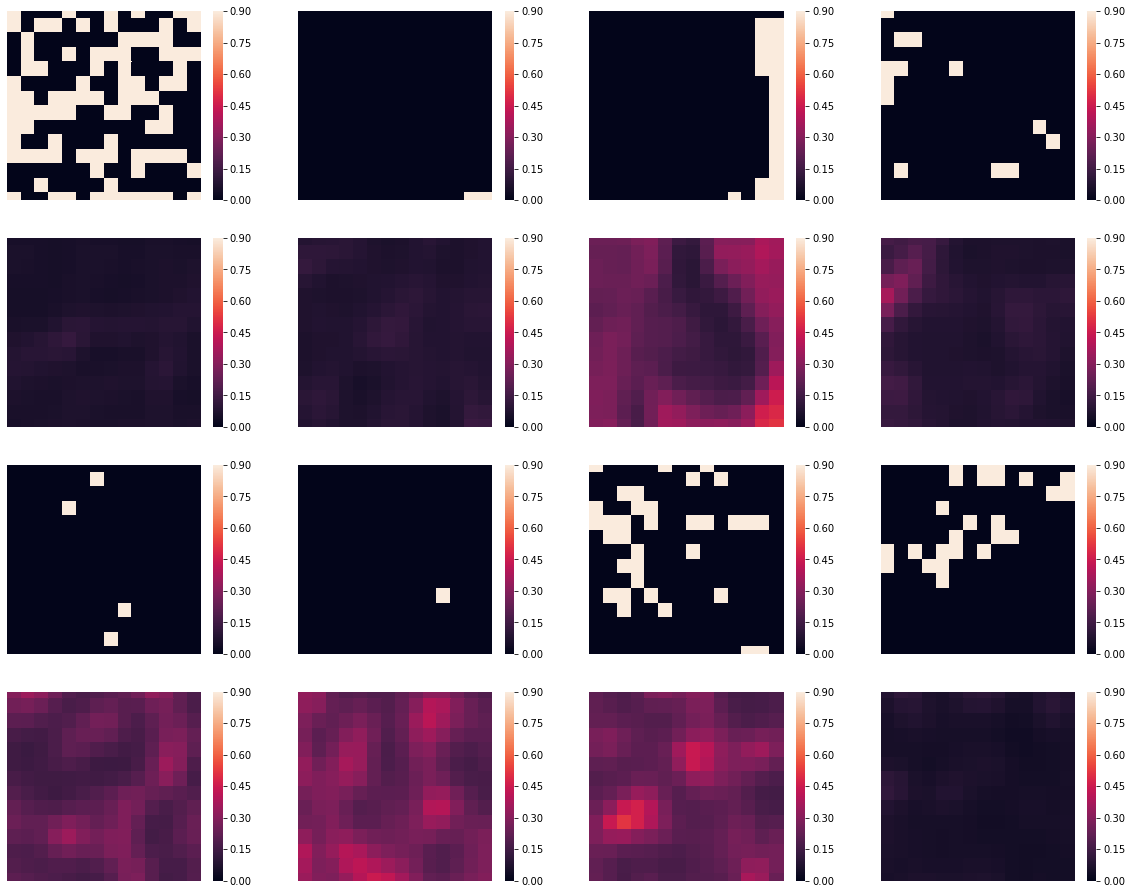

In [83]:
from sklearn.metrics import f1_score
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
preds = []
trues = []
print(matrix_ids)
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: test_lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  clipping_params['rmax']: rmax_epoch,
                                  clipping_params['rmin']: rmin_epoch,
                                  clipping_params['dmax']: dmax_epoch,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    y2 = np.copy(y)
    #y[np.where(y > 0.4)] = 1.0
    #y[np.where(y < 0.4)] = 0.
    #y[np.where(y >= 0.4)] = 1.
    #dc = np.around(dice_loss(test_y[idx].flatten(), y2.flatten()), 3)
    true = test_y[idx].reshape(14, 14)
    #y[np.where(y > 0.4)] = 1.
    identify_alignment(true, y)
    #f1 = f1_score(true.flatten(), y.flatten())
    #print(i, f1, (1-f1)*np.sum(true))
    #if np.sum(true[1:-1]) > 0 and np.sum(y[1:-1]) > 0:
    #    print(i, assd(true[1:-1], y[1:-1]))
    #print(i, np.sum(abs(true - y)))
    trues.append(true)
    
    
""


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)
# 448"109, ""
start = start + 8 
# 50, 64, 66, 83, 94


In [77]:
train_ids = [x for x in range(train_x.shape[0])]
train_ids = sorted(train_ids)
start = 25

6
[25, 26, 27, 28, 29, 30, 31, 32, 33]


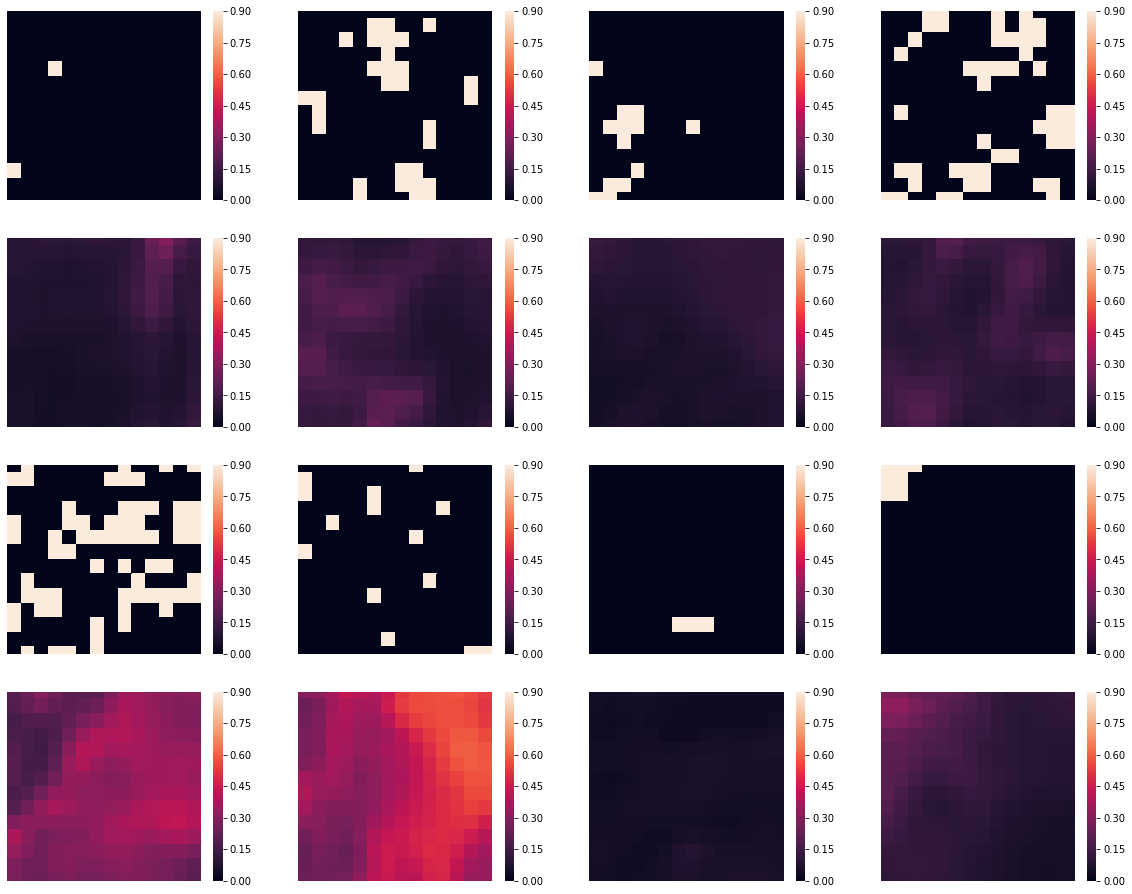

In [78]:
#atrix_ids = random.sample(755, 4)
matrix_ids = [train_ids[start], train_ids[start + 1], train_ids[start + 2], train_ids[start + 3], train_ids[start + 4],
             train_ids[start + 5], train_ids[start + 6], train_ids[start + 7], train_ids[start + 8]]

preds = []
trues = []
print(start//4)
print(matrix_ids)
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  clipping_params['rmax']: rmax_epoch,
                                  clipping_params['rmin']: rmin_epoch,
                                  clipping_params['dmax']: dmax_epoch,
                                  })
    y = np.array(y).reshape(14, 14)
    #y[np.where(y > 0.3)] = 0.85
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    #identify_alignment(true, y)
    trues.append(true)
    
start += 8

to_plot = trues[0:4] + preds[0:4] + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 4, ncols = 4)  